In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import pandas as pd
import PIL
import numpy as np 
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report, log_loss
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define the new dataset

Keep in mind we are inheriting the Dataset base-class. And we have to override 2 methods:
 - \____len____
 - \____getitem____

1. load_image_and_target reads the data from the csv file and converts the image array into a PIL object - this is not mandatory but useful, as many handy functions like transform, operate on PIL.Images
2. getitem, takes a index and it should properly return for every number between (0, and len)
3. len should return the number of samples (images) in your dataset

In [13]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):
        
        self.metadata_df = metadata_df.copy()
        self.transform = transform
    
    def load_image_and_target(self,index):
        # .iloc is short for integer loc it returns a row of data based on its ored not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L'), oneimage[0]
        return image, y
        
    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)
            
        return X, y

    def collate_func(self, batch):
        pass

    
dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=0.1)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

### our datasets supports getitem wich means we can do:

In [14]:
image, label = fmnist_train[0]
print(type(image))
print(type(label), label)

image, label = fmnist_train.load_image_and_target(0)
print(type(image), image)

<class 'torch.Tensor'>
<class 'numpy.int64'> 4
<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=28x28 at 0x7FDDDC1C3C88>


In [15]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32)
batch_iterator = iter(fmnist_dl)
X, y = next(batch_iterator)

for batch in fmnist_dl:
    break

### Explore your dataset
Its always good to start with getting some inside about your dataset. Thats usuall much easier and less important in image datasets - but it does not mean you should not do it.

Things you should always think about working with an image dataset are:
- Check target distribiution (counts) do you see a strong imbalance?
- Check sizes of images, if not all images are of the same size you might destroy your data with wrong transformations
 

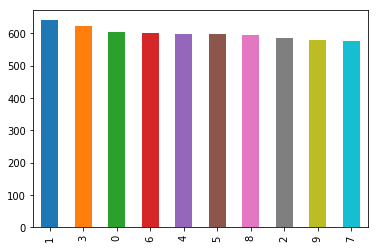

In [16]:
dftrain.label.value_counts().plot(kind='bar')

### visualize a batch
Its always a good idea to sanity check the output of our loaders

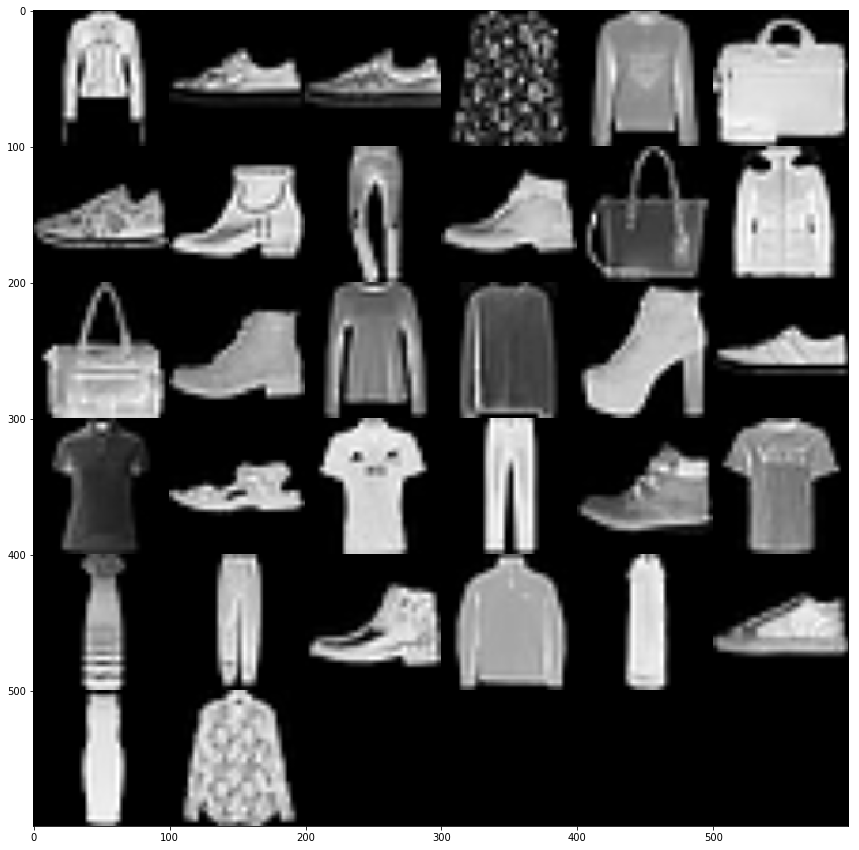

In [17]:
im = EasyImageList.from_torch_batch(X.repeat(1,3,1,1), # we need to add 3 channels to the images
                                    mean=None, std=None)
im.numpy_grid()

### Define your model architecture
As a baseline model dont  overcomplicate, either use some very simple architecture or go with something well established like resnet. There will be time to go more fancy

Here we define a model with two CONV blocks comprising of a typical:  
*Conv>BN>RELU>POOL* setting

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [19]:
# Always check your model are you atleasy able to make a forward pass and shapes match your expectations?
image = torch.randn(32, 1, 28, 28)
cnn = SimpleCNN(10)
output = cnn(image)
print("input shape:")
print(image.shape)
print("output shape:")
print(output.shape)

input shape:
torch.Size([32, 1, 28, 28])
output shape:
torch.Size([32, 10])


### Define your loss function / crieterion and optimizer
Its a good idea to create some dummy data and pass it trough the cost function to make sure you uderstand what the shapes shoudl be

In case of CrossEntropyLosss We want our predictions to be of shape (BATCH_SIZE, N_CLASSES) and y_true of shape (BS) 
(Basically a vector of number that corespond to the class) 


In [21]:
LR= 0.001
BATCH_SIZE = 128
DATASET_USAGE_SIZE = 0.05

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
RESIZE = 28

cnn = SimpleCNN(10)

OPTIMIZER = 'Adam' # one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders

dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# Lets try to use the criterion with dummy data
yp = torch.randn(BATCH_SIZE, 10)
yt = torch.randint(10, (BATCH_SIZE,))
criterion(yp, yt.long())

len(fmnist_train_dl)
len(dftrain)

3000

In [22]:
def evaluate_model(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = cnn(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(ac))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
    
    
            
collect = []
for epoch in range(50):
    lossacc = 0
    for i, batch in enumerate(fmnist_train_dl):
        optimizer.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X)
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()  
        collect.append(float(loss.detach().cpu().numpy()))  
        
    lltest, acctest = evaluate_model(cnn, fmnist_test_dl)
    lltrain, acctrain = evaluate_model(cnn, fmnist_train_dl)
    print("test: loss: {}  acc: {}".format(lltest, acctest))
    print("train: loss: {}  acc: {}".format(lltrain, acctrain))



test: loss: 1.9045668959617614  acc: 0.729
train: loss: 1.9072027513980865  acc: 0.736
test: loss: 1.3252818832993507  acc: 0.795
train: loss: 1.3190165479580562  acc: 0.809
test: loss: 1.1832485405802726  acc: 0.829
train: loss: 1.1698102172116438  acc: 0.8433333333333334
test: loss: 1.133681135982275  acc: 0.835
train: loss: 1.1144983769257863  acc: 0.861
test: loss: 1.0939651733338833  acc: 0.845
train: loss: 1.0696416834096114  acc: 0.8746666666666667
test: loss: 1.067528890877962  acc: 0.852
train: loss: 1.0384913328811527  acc: 0.883
test: loss: 1.0387952419891953  acc: 0.853
train: loss: 1.004820489389201  acc: 0.8986666666666666
test: loss: 1.0193824648708105  acc: 0.854
train: loss: 0.980555935750405  acc: 0.9063333333333333
test: loss: 0.9997227285690605  acc: 0.854
train: loss: 0.9559691818989813  acc: 0.914
test: loss: 0.9817646401040256  acc: 0.854
train: loss: 0.9345836519251267  acc: 0.9236666666666666


KeyboardInterrupt: 

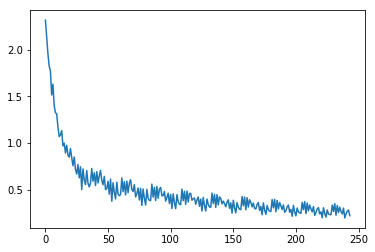

In [24]:
plt.plot(collect)

### Questions/Exercises
- why do we use torch.no_grad():
- Try changing the kernel size of the CNN's what is your intuition should we use a smaller or bigger kernel?
- Get the output of the first cnn, look at its shape and how it looks
- Add dropout to the network, where does it make sense? To put it?
- 

# Crude LR-finder implementation

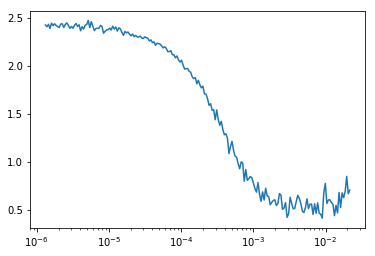

In [158]:
losses = []
lrs = []

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-8
    

for i, batch in enumerate(fmnist_train_dl):
    print(i)
    optimizer.zero_grad()
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = cnn(X)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    current_lr = lr = optimizer.param_groups[0]['lr']
    losses.append(loss)
    lrs.append(current_lr)

    if loss > 10:
        break

    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr * 1.05

    collect.append(float(loss.detach().cpu().numpy()))  

    
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
df = df[100:300]
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')